# WiFind: Indoor Localization via WiFi

# 1. Introduction

> This notebook summarizes the operational workflow of the project. For full details, please refer to the PDF report available in the `/docs/REPORT.pdf` directory.

The problem addressed in this notebook concerns indoor localization, i.e., the ability to determine a user's position inside a building by leveraging the existing Wi-Fi network.

For this purpose, the **WiFi Fingerprinting** technique was applied, which is based on analyzing the signal strength (RSSI) received from various Access Points to classify the position using a supervised model.

The entire process took place in the Ercolani building at the University of Bologna, where real data was collected to build a custom dataset.  
The ultimate goal is to predict which room a user is in, based solely on Wi-Fi signal measurements.

This notebook documents the main operational phases:
- exploratory data analysis;
- preprocessing and splitting;
- model training;
- results evaluation.

In [23]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

## 2. Exploratory Data Analysis

This section presents two plots:

- **Histogram of detections per Access Point (AP):**  
  shows the number of times each AP was detected in the dataset, useful for identifying the most relevant APs.

- **Heatmap of average RSSI signal strength:**  
  displays the mean signal for each combination of room and condition (`Empty`, `Crowded`), useful for observing the effect of people on signal propagation.

These visualizations help to understand the quality and coverage of the dataset.


In [24]:
# Loading dataset and extracting AP columns
file_path = "../../data/raw/wifi_fingerprinting_dataset_raw.csv"
df = pd.read_csv(file_path)

ap_columns = [col for col in df.columns if "AP" in col]

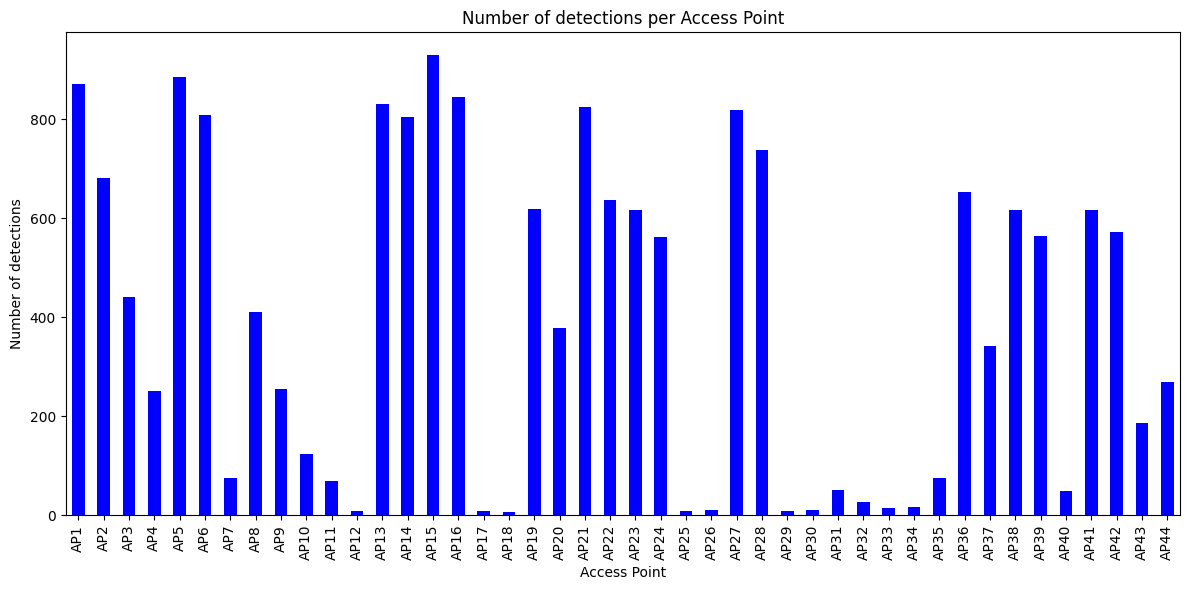

In [26]:
# Histogram: number of detections per Access Point
ap_counts = df[ap_columns].notnull().sum().reindex(sorted(ap_columns, key=lambda x: int(x[2:])))

plt.figure(figsize=(12, 6))
ap_counts.plot(kind='bar', color='blue')
plt.title("Number of detections per Access Point")
plt.xlabel("Access Point")
plt.ylabel("Number of detections")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

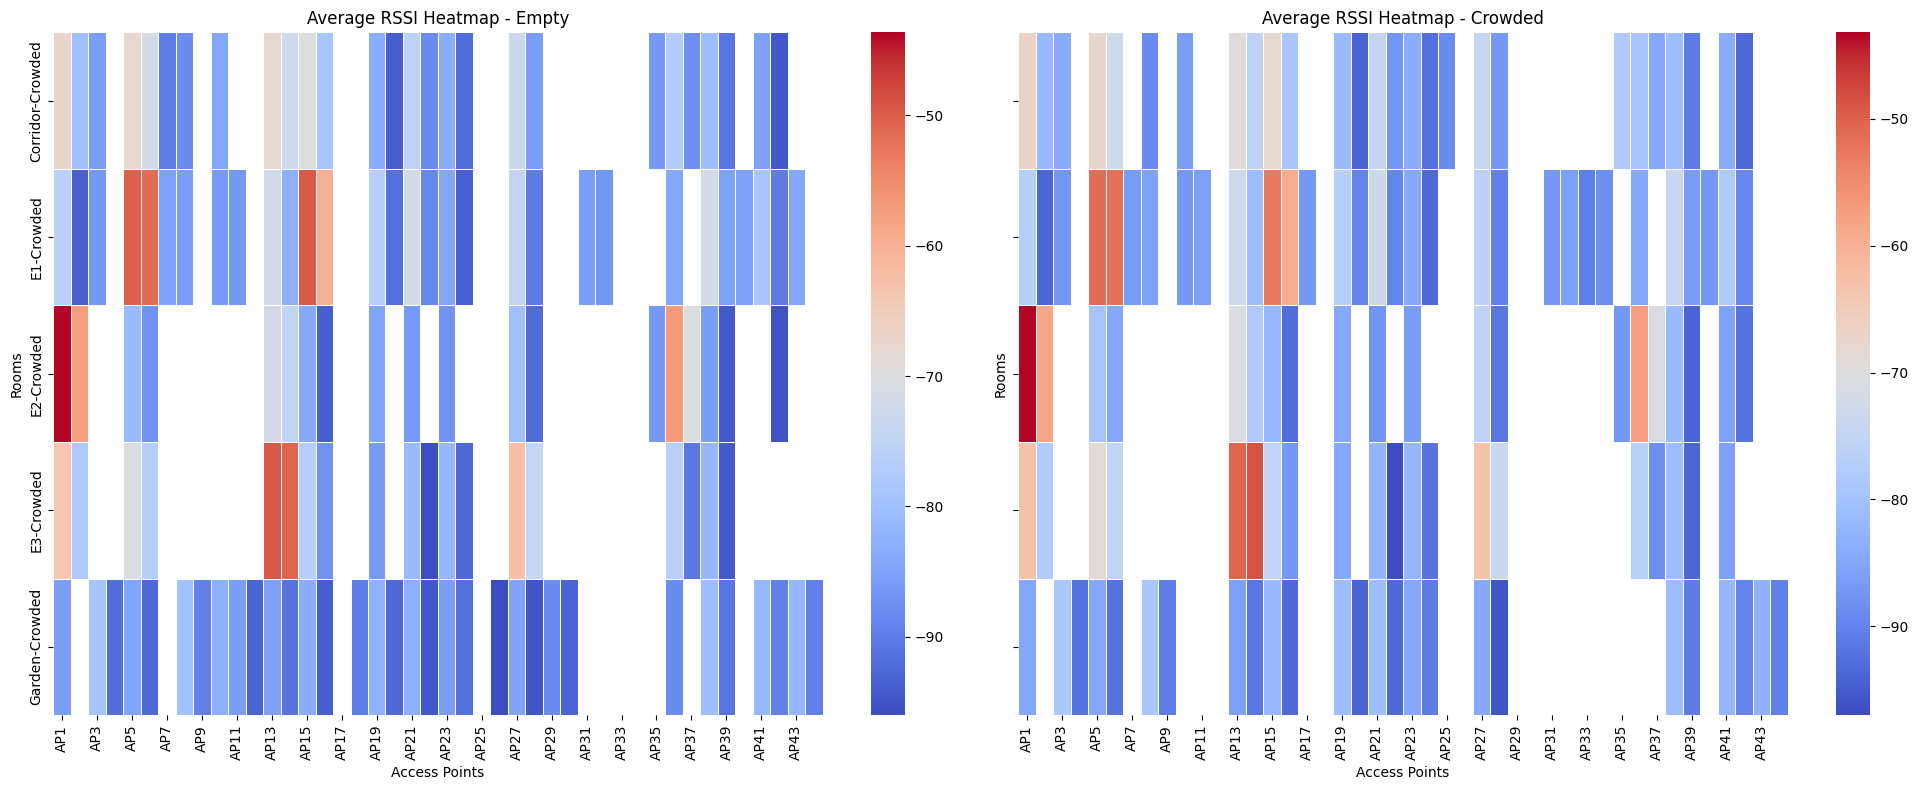

In [28]:
# Heatmap of average RSSI signal by room and situation
pivot_df = df.groupby(["Aula", "Situazione"])[ap_columns].mean()

fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

sns.heatmap(pivot_df.loc[(slice(None), "Empty"), :], cmap="coolwarm", annot=False, cbar=True, linewidths=0.5, ax=axes[0])
axes[0].set_title("Average RSSI Heatmap - Empty")
axes[0].set_xlabel("Access Points")
axes[0].set_ylabel("Rooms")
axes[0].tick_params(axis='x', rotation=90)

sns.heatmap(pivot_df.loc[(slice(None), "Crowded"), :], cmap="coolwarm", annot=False, cbar=True, linewidths=0.5, ax=axes[1])
axes[1].set_title("Average RSSI Heatmap - Crowded")
axes[1].set_xlabel("Access Points")
axes[1].set_ylabel("Rooms")
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

## 3. Datasets Used

For classification tasks, the `binarized` dataset is used, where each value represents the **presence (`1`) or absence (`0`)** of a Wi-Fi signal received from an Access Point (AP).

The dataset is divided into:
- **Empty**: empty classrooms;
- **Crowded**: classrooms with people;
- **Hybrid**: combination of both.

For each variant, the data is split into a training set (70%) and a test set (30%), stratified by class (`Aula`) to ensure consistency between sets.

> The code also keeps paths to other datasets (`cut400`, `normalized`) for possible testing, but all analyses and results reported are based exclusively on the binarized dataset.


In [38]:
# Loading datasets (default: binarized)
file_path_bin = "../../data/processed/wifi_fingerprinting_dataset_binarized.csv"
file_path_norm = "../../data/processed/wifi_fingerprinting_dataset_normalized.csv"
file_path_400 = "../../data/processed/wifi_fingerprinting_dataset_cut_400_ap22.csv"

# Load binarized dataset by default
df = pd.read_csv(file_path_bin, sep=',')

# # Fill NaN with -200 if any (though binarized should not contain NaN)
df.fillna(-200, inplace=True)

# Create separate datasets based on room conditions
df_empty = df[df["Situazione"] == "Empty"].drop(columns=["Situazione"])
df_crowded = df[df["Situazione"] == "Crowded"].drop(columns=["Situazione"])
df_hybrid = df.drop(columns=["Situazione"])

# Split the data into training and test sets (70/30)
def split_data(df):
    X = df.drop(columns=["Aula"])
    y = df["Aula"]

    # When splitting the data, we set:
    # - random_state: a seed to get the same train/test split every time -> keeping it fixed allows to compare the 
    #   results obtained for all the dataframe.
    # - stratify: ensures that the train, validation, and test sets maintain the same class distribution as the  
    #   original dataset.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    return X_train, X_test, y_train, y_test

X_train_empty, X_test_empty, y_train_empty, y_test_empty = split_data(df_empty)
X_train_crowded, X_test_crowded, y_train_crowded, y_test_crowded = split_data(df_crowded)
X_train_hybrid, X_test_hybrid, y_train_hybrid, y_test_hybrid = split_data(df_hybrid)

# Print sample counts for each split
def print_split_info(name, X_train, X_test):
    print(f"\n{name} dataset:")
    print(f"  Train set:      {X_train.shape[0]} samples")
    print(f"  Test set:       {X_test.shape[0]} samples")

print_split_info("Empty", X_train_empty, X_test_empty)
print_split_info("Crowded", X_train_crowded, X_test_crowded)
print_split_info("Hybrid", X_train_hybrid, X_test_hybrid)


Empty dataset:
  Train set:      338 samples
  Test set:       146 samples

Crowded dataset:
  Train set:      349 samples
  Test set:       150 samples

Hybrid dataset:
  Train set:      688 samples
  Test set:       295 samples


## 4. KNN Model Training

The chosen model is **K-Nearest Neighbors (KNN)**, which classifies each instance based on the `k` closest examples according to a distance metric.

### Hyperparameter Optimization

For each scenario (`Empty`, `Crowded`, `Hybrid`), a **Grid Search** with **Stratified K-Fold Cross Validation (4-fold)** is applied to select the optimal parameters.

Optimized parameters:
- `n_neighbors` (between 3 and 19)
- `weights` (uniform/distance)
- `algorithm` (ball_tree/brute)
- `metric` (euclidean/manhattan)

In [32]:
# Grid Search with Cross-Validation. Parameters tuning for empty, crowded and hybrid situations is calculated by 
# GridSearchCV. Iterates on all different parameters given and elaborate wich one give the best results based on a 
# certain metric.

def find_best_knn(X_train, y_train):
    param_grid = {
        'n_neighbors': range(3, 20),
        'weights': ['uniform', 'distance'],
        'algorithm': ['ball_tree', 'brute'], #'kd_tree'
        'metric': ['euclidean', 'manhattan'], #'minkowski'
    }

    knn = KNeighborsClassifier()

    # StratifiedKFold: splits data into k folds, but ensures each fold has the same distribution of class labels
    grid_search = GridSearchCV(knn, param_grid, cv=StratifiedKFold(n_splits=4), scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    return grid_search.best_params_, grid_search.best_score_

best_params_empty, acc_empty = find_best_knn(X_train_empty, y_train_empty)
best_params_crowded, acc_crowded = find_best_knn(X_train_crowded, y_train_crowded)
best_params_hybrid, acc_hybrid = find_best_knn(X_train_hybrid, y_train_hybrid)

print(f"Empty -> Best params: {best_params_empty}, Best accuracy: {acc_empty:.4f}")
print(f"Crowded -> Best params: {best_params_crowded}, Best accuracy: {acc_crowded:.4f}")
print(f"Hybrid -> Best params: {best_params_hybrid}, Best accuracy: {acc_hybrid:.4f}")

Empty -> Best params: {'algorithm': 'brute', 'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'distance'}, Best accuracy: 0.9793
Crowded -> Best params: {'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}, Best accuracy: 0.9340
Hybrid -> Best params: {'algorithm': 'brute', 'metric': 'euclidean', 'n_neighbors': 16, 'weights': 'uniform'}, Best accuracy: 0.9302


## 5. Model Evaluation

After optimization, each model is tested on all three scenarios (`Empty`, `Crowded`, `Hybrid`) using a **cross-testing** approach.

For each combination, the following metrics are calculated:
- **Accuracy**
- **Precision**
- **Recall**
- **F1-score**

The metrics are weighted according to the class distribution.

In [34]:
# Function to evaluate the model on the test set and display summary metrics
def evaluate_on_test_summary(X_train, y_train, X_test, y_test, best_params, label, label2):
    model = KNeighborsClassifier(**best_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    type_dict = {
        "Train Model": label,
        "Test Model": label2,
        "Neighbors": best_params['n_neighbors'],
        "Weights": best_params['weights'],
        "Algorithm": best_params['algorithm'],
        "Metric": best_params['metric'],        
    }
    metric_dict = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1
    }

    return type_dict, metric_dict
    
# Define scenario labels
em = "Empty"
cr = "Crowded"
hy = "Hybrid"
results = []
type_data = []
metric_data = []

# Cross-testing evaluation
results.append(evaluate_on_test_summary(X_train_empty, y_train_empty, X_test_empty, y_test_empty, best_params_empty, em, em))
results.append(evaluate_on_test_summary(X_train_empty, y_train_empty, X_test_crowded, y_test_crowded, best_params_empty, em, cr))
results.append(evaluate_on_test_summary(X_train_empty, y_train_empty, X_test_hybrid, y_test_hybrid, best_params_empty, em, hy))

results.append(evaluate_on_test_summary(X_train_crowded, y_train_crowded, X_test_empty, y_test_empty, best_params_crowded, cr, em))
results.append(evaluate_on_test_summary(X_train_crowded, y_train_crowded, X_test_crowded, y_test_crowded, best_params_crowded, cr, cr))
results.append(evaluate_on_test_summary(X_train_crowded, y_train_crowded, X_test_hybrid, y_test_hybrid, best_params_crowded, cr, hy))

results.append(evaluate_on_test_summary(X_train_hybrid, y_train_hybrid, X_test_empty, y_test_empty, best_params_hybrid, hy, em))
results.append(evaluate_on_test_summary(X_train_hybrid, y_train_hybrid, X_test_crowded, y_test_crowded, best_params_hybrid, hy, cr))
results.append(evaluate_on_test_summary(X_train_hybrid, y_train_hybrid, X_test_hybrid, y_test_hybrid, best_params_hybrid, hy, hy))

for result in results:
    type_dict, metric_dict = result
    type_data.append(type_dict)
    metric_data.append(metric_dict)

type_df = pd.DataFrame(type_data)
metric_df = pd.DataFrame(metric_data)

print("\nSummary of test set results (Model Parameters):")
print(type_df.round(3))

print("\nSummary of test set results (Metrics):")
print(metric_df.round(3))



Summary of test set results (Model Parameters):
  Train Model Test Model  Neighbors   Weights  Algorithm     Metric
0       Empty      Empty          6  distance      brute  manhattan
1       Empty    Crowded          6  distance      brute  manhattan
2       Empty     Hybrid          6  distance      brute  manhattan
3     Crowded      Empty         15  distance  ball_tree  manhattan
4     Crowded    Crowded         15  distance  ball_tree  manhattan
5     Crowded     Hybrid         15  distance  ball_tree  manhattan
6      Hybrid      Empty         16   uniform      brute  euclidean
7      Hybrid    Crowded         16   uniform      brute  euclidean
8      Hybrid     Hybrid         16   uniform      brute  euclidean

Summary of test set results (Metrics):
   Accuracy  Precision  Recall  F1-score
0     0.932      0.935   0.932     0.931
1     0.813      0.808   0.813     0.797
2     0.912      0.912   0.912     0.909
3     0.897      0.909   0.897     0.897
4     0.887      0.884   0

### Confusion Matrices

Nine confusion matrices (3x3) are displayed, where:
- rows indicate the actual classes,
- columns indicate the predictions,
- colors represent the percentage of errors,
- internal values indicate the absolute number of cases.


Confusion matrices:


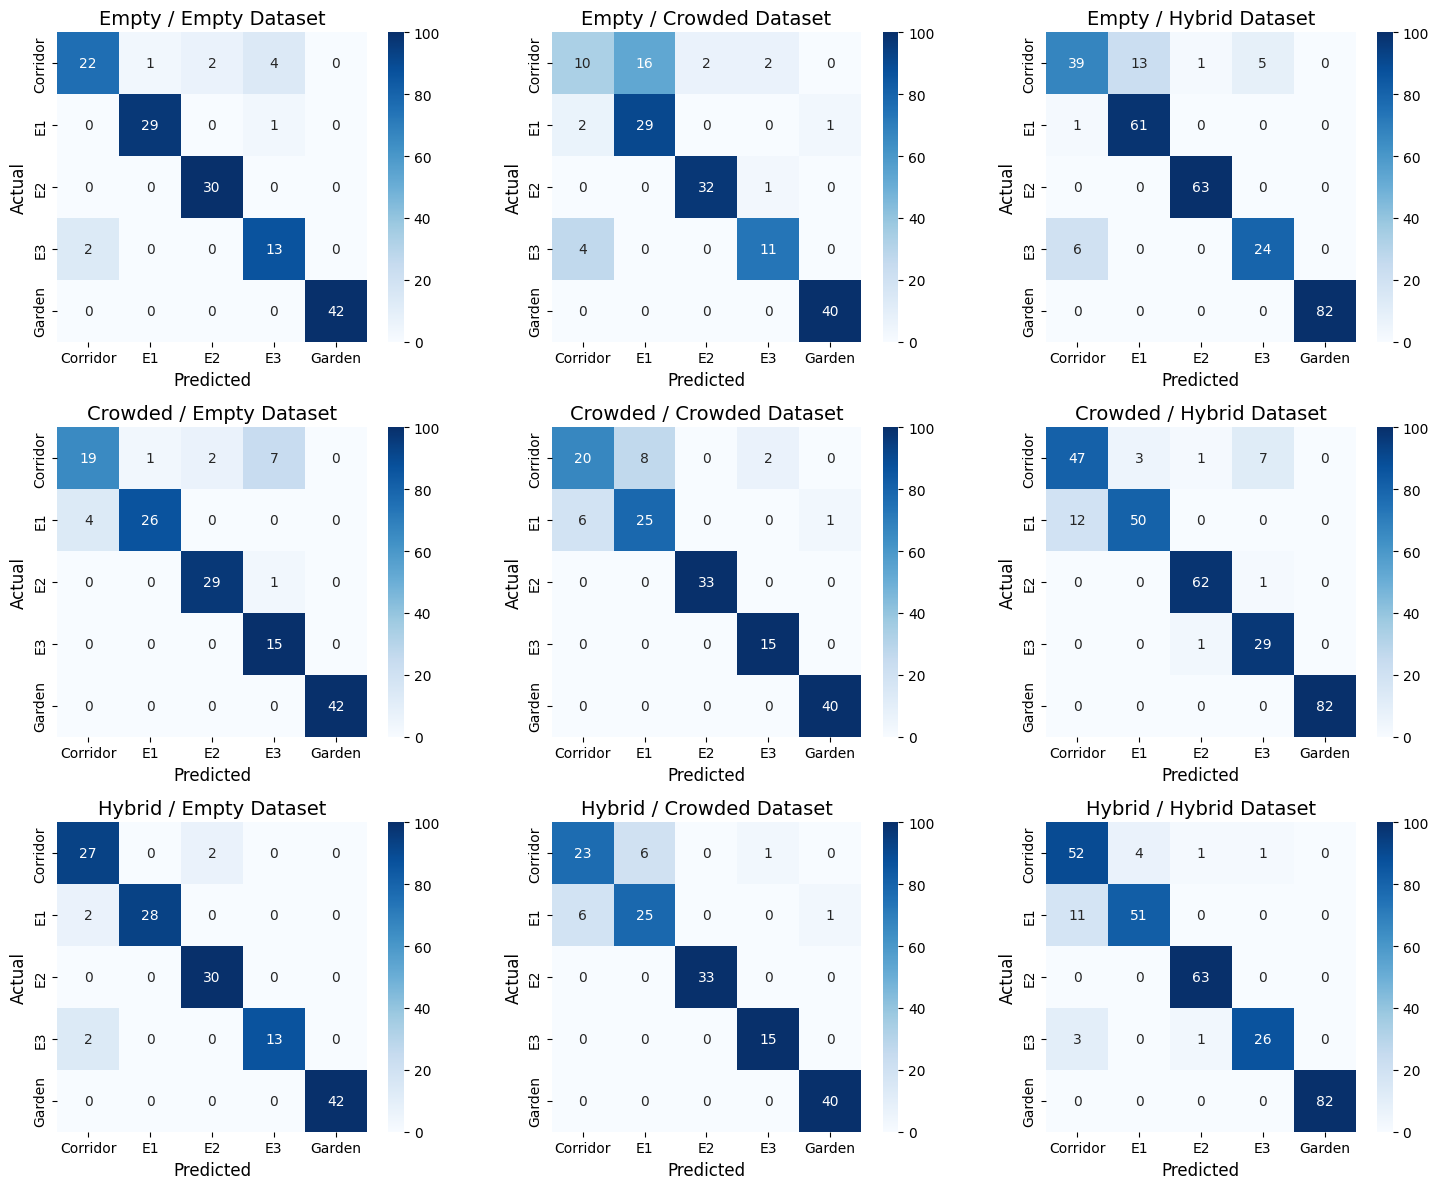

In [35]:
# Plot confusion matrices for the best models on a 3x3 grid
def plot_conf_matrices():
    datasets = [
        (f"{em} / {em}", X_train_empty, y_train_empty, X_test_empty, y_test_empty, best_params_empty),
        (f"{em} / {cr}", X_train_empty, y_train_empty, X_test_crowded, y_test_crowded, best_params_empty),
        (f"{em} / {hy}", X_train_empty, y_train_empty, X_test_hybrid, y_test_hybrid, best_params_empty),

        (f"{cr} / {em}", X_train_crowded, y_train_crowded, X_test_empty, y_test_empty, best_params_crowded),
        (f"{cr} / {cr}", X_train_crowded, y_train_crowded, X_test_crowded, y_test_crowded, best_params_crowded),
        (f"{cr} / {hy}", X_train_crowded, y_train_crowded, X_test_hybrid, y_test_hybrid, best_params_crowded),

        (f"{hy} / {em}", X_train_hybrid, y_train_hybrid, X_test_empty, y_test_empty, best_params_hybrid),
        (f"{hy} / {cr}", X_train_hybrid, y_train_hybrid, X_test_crowded, y_test_crowded, best_params_hybrid),
        (f"{hy} / {hy}", X_train_hybrid, y_train_hybrid, X_test_hybrid, y_test_hybrid, best_params_hybrid),
    ]

    rows, cols = 3, 3
    fig, axes = plt.subplots(rows, cols, figsize=(15,12))

    for ax, (label, X_train, y_train, X_test, y_test, best_params) in zip(axes.flatten(), datasets):

        model = KNeighborsClassifier(**best_params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        class_labels = sorted(np.unique(np.concatenate((y_train, y_test))))  
        cm = confusion_matrix(y_test, y_pred, labels=class_labels)
        cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
        cm_percentage = np.nan_to_num(cm_percentage)

        sns.heatmap(cm_percentage, annot=cm, square=1, fmt="d", cmap='Blues',
                    xticklabels=class_labels, yticklabels=class_labels, ax=ax, cbar=True)

        ax.set_title(f"{label} Dataset", fontsize=14)
        ax.set_xlabel("Predicted", fontsize=12)
        ax.set_ylabel("Actual", fontsize=12)

    for i in range(len(datasets), rows * cols):
        # Hide unused subplots
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()

# Display the confusion matrices
print("\nConfusion matrices:")
plot_conf_matrices()